In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error

## Read and aggregate data

In [2]:
# read daily data
processed_dfs = []
for filename in sorted(os.listdir('data/aggregated_individual_data/')):
    with open('data/aggregated_individual_data/'+filename, 'r') as f: # open in readonly mode
        df = pd.read_csv(f)
        df.drop('Unnamed: 0', inplace=True, axis = 1)
        processed_dfs.append(df)

In [3]:
# aggregate the data
vars = ['time', 'weekday', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'sleep', 'sleep_before', 'mood_yesterday', 'mood_target', 'target_bw' ]

forest_data = pd.DataFrame(columns = vars)

n_days = 5

for i, df_org in enumerate(processed_dfs):
    df = df_org.copy()

    # scale the data for each individual
    for j, col in enumerate(vars[3:len(df.columns)]):
        # min max scaling
        df[col] = (df[col]-df[col].min())/(df[col].max() - df[col].min())
        #df[col] = (df[col]-df[col].mean())
        df[col] = df[col].fillna(0)
    
    # average the data and add data for the previous day / that doesn't need to be averaged
    for j in range(len(df)-n_days-1):
        means = pd.DataFrame(df.iloc[j:j+n_days, 2:len(df.columns)].mean())
        forest_data = pd.concat([forest_data, means.transpose()], ignore_index=True)
        # add time
        forest_data.iloc[-1, 0] = df['time'].iloc[j+n_days+1]
        # add weekday
        forest_data.iloc[-1, 1] = df['weekday'].iloc[j+n_days+1]
        # add sleep of night before
        forest_data.iloc[-1, -4] = df['sleep'].iloc[j+n_days+1]
        # add mood of current day
        forest_data.iloc[-1, -3] = df['mood'].iloc[j+n_days]
        # add target mood
        forest_data.iloc[-1, -2] = df['mood'].iloc[j+n_days+1]


# delete columns with too many nan or 0 values
for col in forest_data.columns:
    if (sum(forest_data[col] == 0)/len(forest_data[col])) > 0.5:
        forest_data = forest_data.drop(col, axis = 1)

# calculate if the mood was better or worse the day before
forest_data['target_bw'] = forest_data['mood_target'] - forest_data['mood_yesterday']

In [4]:
forest_data.head()

,time,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.entertainment,appCat.other,appCat.social,appCat.travel,appCat.utilities,sleep,sleep_before,mood_yesterday,mood_target,target_bw
0,2014-03-27,3,6.45,0.782222,0.43,0.489925,0.383056,0.38,0.10,0.065004,...,0.068468,0.096459,0.434987,0.170016,0.153470,0.409441,0.327224,6.4,7.0,0.6
1,2014-03-28,4,6.48,0.764444,0.46,0.492840,0.423441,0.26,0.10,0.043903,...,0.060816,0.077870,0.420881,0.056621,0.117417,0.436149,0.48541,7.0,6.4,-0.6
2,2014-03-29,5,6.56,0.728889,0.51,0.558113,0.591388,0.24,0.10,0.052188,...,0.084745,0.071502,0.501566,0.057861,0.134449,0.348596,0.262787,6.4,8.0,1.6
3,2014-03-30,6,6.52,0.657778,0.51,0.537830,0.598358,0.34,0.10,0.170968,...,0.110122,0.104798,0.507858,0.198205,0.202164,0.375157,0.670593,8.0,7.5,-0.5
4,2014-03-31,0,6.96,0.551111,0.71,0.505415,0.508903,0.22,0.15,0.165192,...,0.120416,0.120220,0.368342,0.152699,0.257994,0.359603,0.150961,7.5,7.2,-0.3


## Random Forrest classifier

In [5]:
# get the dataset for prediction
X = forest_data.iloc[:,1:-2].copy()
# get target variable as int for classification
y = forest_data.loc[:, 'mood_target'].copy()

In [6]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train_cl = y_train.astype(int)
y_test_cl = y_test.astype(int)

### Hyper parameter tuning
Best values were n_estimators = 483 and max_depth = 5. Thus we choose n_estimators = 500 and max_depth = 5.

In [7]:
# # Hyperparameter tuning
# param_dist = {'n_estimators': randint(10,500),
#               'max_depth': randint(1,15)}

# # Create a random forest classifier
# rf = RandomForestClassifier(n_jobs = -1)

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=200)

# # Fit the random search object to the data
# rand_search.fit(X_train, y_train_cl)

In [8]:
# rf_best = rand_search.best_estimator_
# print('Best hyperparameters:',  rand_search.best_params_)

### Unbalanced classes

In [9]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 5,n_jobs = -1)

# fit the best rf
rf = rf.fit(X_train, y_train_cl)
y_pred_cl = rf.predict(X_test)
y_train_cl_pred = rf.predict(X_train)

In [10]:
# confusion matrix and feature importance
cm_test = confusion_matrix(y_test_cl, y_pred_cl, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm_test, display_labels=rf.classes_)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

### Balanced classes

In [11]:
rf_balanced = rf
rf_balanced.class_weight = 'balanced_subsample'
rf_balanced = rf_balanced.fit(X_train, y_train_cl)
y_pred_balanced = rf_balanced.predict(X_test)

In [12]:
# confusion matrix
cm_balanced = confusion_matrix(y_test_cl, y_pred_balanced, labels=rf.classes_)
disp_balanced = ConfusionMatrixDisplay(cm_balanced, display_labels=rf.classes_)

### Reducing features

In [13]:
rf.class_weight = None

rfe = RFE(estimator=rf, n_features_to_select=3)
pipeline = Pipeline(steps=[('s',rfe),('m',rf)])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
n_scores = cross_val_score(pipeline, X_train, y_train_cl, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

pipeline.fit(X_train, y_train_cl)

# get reduced feature set
features = pipeline[:-1].get_feature_names_out()

y_pred_reduced = pipeline.predict(X_test)
y_train_pred_reduced = pipeline.predict(X_train)

/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated 

In [14]:
# confusion matrix and feature importance
cm_reduced = confusion_matrix(y_test_cl, y_pred_reduced, labels=rf.classes_)
disp_reduced = ConfusionMatrixDisplay(cm_reduced, display_labels=rf.classes_)

feature_importances_red = pd.DataFrame(rf_balanced.feature_importances_,
                                   index = features,
                                   columns=['importance']).sort_values('importance',ascending=False)

### Plotting the results

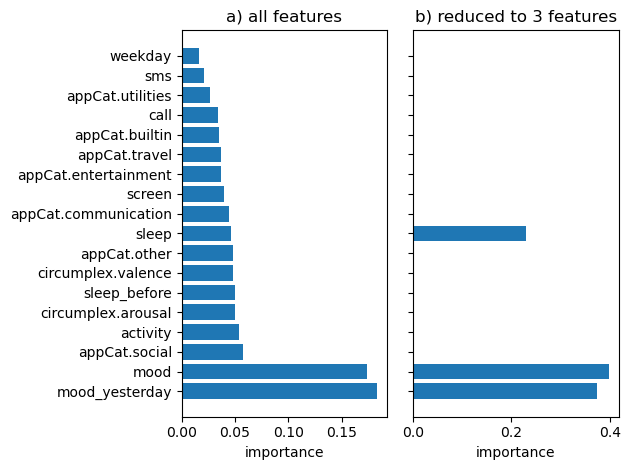

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.barh(feature_importances.index,feature_importances.importance)
ax2.barh(feature_importances_red.index,feature_importances_red.importance)

ax1.set_title('a) all features')
ax2.set_title('b) reduced to 3 features')
ax1.set_xlabel('importance')
ax2.set_xlabel('importance')

plt.tight_layout()

plt.savefig('figures/feature_importance.png', dpi = 300)

In [16]:
# comparison
cm_comp = confusion_matrix(y_test_cl, X_test['mood_yesterday'].astype(int), labels=rf.classes_)
disp_comp = ConfusionMatrixDisplay(cm_comp, display_labels=rf.classes_)


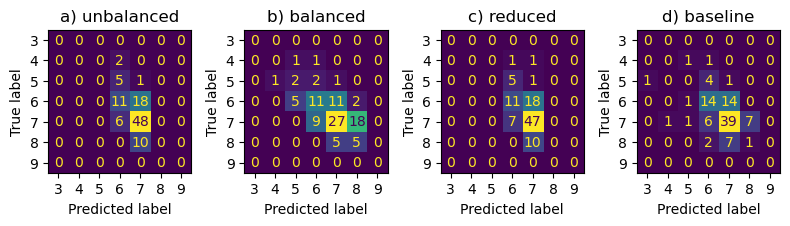

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(8,4)
disp.plot(ax=ax1)
disp.im_.colorbar.remove()
disp_balanced.plot(ax=ax2)
disp_balanced.im_.colorbar.remove()
disp_reduced.plot(ax=ax3)
disp_reduced.im_.colorbar.remove()
disp_comp.plot(ax=ax4)
disp_comp.im_.colorbar.remove()

ax1.set_title('a) unbalanced')
ax2.set_title('b) balanced')
ax3.set_title('c) reduced')
ax4.set_title('d) baseline')

plt.tight_layout()

plt.savefig('figures/confusion.png', dpi = 300)

## Random Forest Regressor

In [19]:
# using the same hyper parameters
rf_reg = RandomForestRegressor(max_depth = 5, n_estimators = 500, n_jobs = -1)

In [21]:
rf_reg = rf_reg.fit(X_train, y_train)
y_pred_reg = rf_reg.predict(X_test)
y_train_pred_reg = rf_reg.predict(X_train)

MSE_test = mean_squared_error(y_test,y_pred_reg)
MSE_train = mean_squared_error(y_train,y_train_pred_reg)
MSE_comp = mean_squared_error(y_test, X_test['mood_yesterday'])
print('MSE test:', MSE_test)
print('MSE train:',MSE_train)
print('MSE comp:',MSE_comp)

MSE test: 0.3727966837759931
MSE train: 0.2611044049054087
MSE comp: 0.5223081683168316


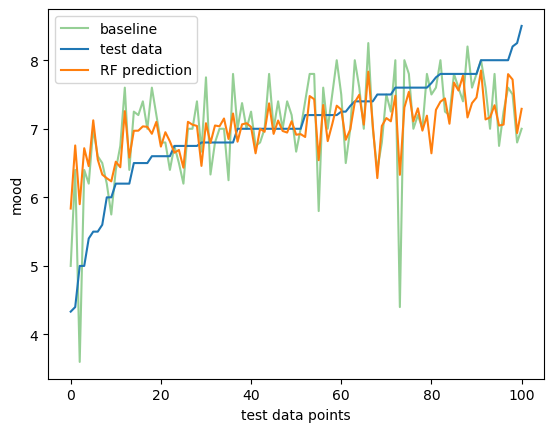

In [22]:
# plott against test and baseline
test_arr = y_test.to_numpy()
p = test_arr.argsort()
test_arr = test_arr[p]
pred_arr = y_pred_reg[p]
comp_arr = X_test['mood_yesterday'].to_numpy()[p]

plt.plot(comp_arr, label = 'baseline', alpha = 0.5, color = 'C2')
plt.plot(test_arr, label = 'test data')
plt.plot(pred_arr, label = 'RF prediction')





plt.ylabel('mood')
plt.xlabel('test data points')
plt.legend()
plt.savefig('figures/rf_numerical.png', dpi = 300)

## Average performance of the RF

In [29]:
# determine the average performance of the regressor
n = 30
MSEs = []
MSEs_base = []
for i in tqdm(range(n)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    rf_reg = rf_reg.fit(X_train, y_train)
    y_pred_reg = rf_reg.predict(X_test)
    MSEs.append(mean_squared_error(y_test,y_pred_reg))

    # base
    MSEs_base.append(mean_squared_error(y_test, X_test['mood_yesterday']))

print(np.mean(MSEs))
print(np.std(MSEs))


100%|██████████| 30/30 [00:12<00:00,  2.40it/s]

0.40951179172023894
0.05880362478562617


In [30]:
print('MSE reg', np.mean(MSEs))
print('MSE std reg', np.std(MSEs))
print('MSE base', np.mean(MSEs_base))
print('MSE std base', np.std(MSEs_base))

MSE reg 0.40951179172023894
MSE std reg 0.05880362478562617
MSE base 0.5744600522552256
MSE std base 0.09150158460901303


In [27]:
# determine average accuracy of the classifier
n = 30
acc_unbal = []
acc_bal = []
acc_red = []
acc_base = []
rf = RandomForestClassifier(n_estimators = 500, max_depth = 5,n_jobs = -1)
for i in tqdm(range(n)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    y_train_cl = y_train.astype(int)
    y_test_cl = y_test.astype(int)

    # unbalanced
    rf = rf.fit(X_train, y_train_cl)
    y_pred_cl = rf.predict(X_test)
    y_train_cl_pred = rf.predict(X_train)
    acc_unbal.append(accuracy_score(y_test_cl, y_pred_cl))

    # balanced
    rf_balanced = rf
    rf_balanced.class_weight = 'balanced_subsample'
    rf_balanced = rf_balanced.fit(X_train, y_train_cl)
    y_pred_balanced = rf_balanced.predict(X_test)
    acc_bal.append(accuracy_score(y_test_cl, y_pred_balanced))

    # reduced
    rf.class_weight = None
    rf = rf.fit(X_train[features], y_train_cl)
    y_pred_red = rf.predict(X_test[features])
    acc_red.append(accuracy_score(y_test_cl, y_pred_red))

    # baseline
    acc_base.append(accuracy_score(y_test_cl, X_test['mood_yesterday'].astype(int)))

    # balanced

100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


In [28]:
print('mean unbal.',np.mean(acc_unbal))
print('std unbal.',np.std(acc_unbal))
print('mean bal.',np.mean(acc_bal))
print('std bal.',np.std(acc_bal))
print('mean red.',np.mean(acc_red))
print('std red.',np.std(acc_red))
print('mean base',np.mean(acc_base))
print('std base',np.std(acc_base))

mean unbal. 0.5844884488448846
std unbal. 0.04647375646975378
mean bal. 0.48415841584158414
std bal. 0.040124467329498176
mean red. 0.5871287128712871
std red. 0.04680072798285155
mean base 0.5105610561056106
std base 0.038404555292625736
